Getting into the right folder and enviroment


In [237]:
from google.colab import drive
drive.mount('/content/drive')
FOLDER_NAME = 'Kaggle-ML/Neuromatch_Project'
FOLDER_PATH = f'drive/My Drive/{FOLDER_NAME}/'
%cd "{FOLDER_PATH}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Kaggle-ML/Neuromatch_Project/'
/content/drive/My Drive/Kaggle-ML/Neuromatch_Project


In [238]:
DATASET_ROOT = 'dataset'
TRAIN_FOLDER = f'{DATASET_ROOT}/Training'
TEST_FOLDER = f'{DATASET_ROOT}/Testing'
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
TRAIN_BATCH_SIZE= 4
TRAIN_NUM_WORKERS= 1
TRAIN_SIZE= 2476
VALIDATION_SIZE = 394

Installing dependencies

In [239]:
import torch
import pathlib
import cv2 
import matplotlib.pyplot as plt 
import imutils


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [240]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
           
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()

    return new_image

In [253]:
class CustomDataset(ImageFolder):
  def __init__(self, root, transforms):
    super(CustomDataset, self).__init__(root=root, transform=transforms)
    self.transform = transforms

  def __getitem__(self, index):
    image_path, target = self.samples[index]

    cv2_image = cv2.imread(image_path)
    cv2_image = crop_brain_contour(cv2_image, plot=True)

    # resize image
    cv2_image = cv2.resize(cv2_image, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
    # normalize values
    cv2_image= cv2_image/255

    sample = transforms.ToTensor()(cv2_image)

    if self.transform:
       sample = self.transform(sample)
    
    return sample, target

In [254]:
# To do Split here!!!!


# Data Augmentation using transforms
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize(512),
                                        transforms.RandomCrop(512),                           
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.RandomRotation(degrees=(30, 70)),
                                        transforms.ToTensor(),
                                     ])

data_path = pathlib.Path('.')/'afhq'  # Using pathlib to be compatible with all OS's
dataset = CustomDataset(TRAIN_FOLDER, transforms=train_transforms)

In [243]:
# Create random split of training vs validation
validation_ds, train_ds = torch.utils.data.random_split(dataset, [VALIDATION_SIZE,TRAIN_SIZE])

In [244]:
train_dataloader = DataLoader(
    train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
    num_workers=TRAIN_NUM_WORKERS, pin_memory=True
)

In [251]:
#Dataloaders output a 4 dimensional tensor - [batch, channel, height, width]
batch = next(iter(train_dataloader))
train_images_batch, train_labels_batch = batch
print(f"Feature batch shape: {train_images_batch.size()}")
print(f"Labels batch shape: {train_labels_batch.size()}")

Feature batch shape: torch.Size([4, 3, 512, 512])
Labels batch shape: torch.Size([4])


In [256]:
batch = next(iter(train_dataloader))

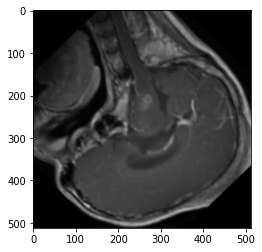

In [255]:
image = train_images_batch[0]
image = image.permute(1,2,0)
plt.imshow(image)

In [247]:
classes_training= dataset.class_to_idx
classes_training

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [248]:
classes = {}
for key,value in classes_training.items():
  classes[value] = key
classes

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

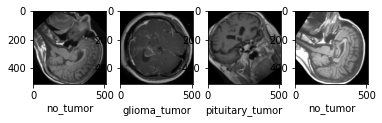

In [249]:
# Show a batch 
def show_batch(batch_images, batch_labels):
  batch,_,_,_ = batch_images.shape
  for i in range(batch):
    # plt subplot subplot(nrows, ncols, index, **kwargs)
    axes = plt.subplot(1,TRAIN_BATCH_SIZE,i+1)
    class_idx = batch_labels[i].item()
    label = classes[class_idx]
    axes.set(xlabel=label)
    plt.imshow(batch_images[i].permute(1,2,0))

  plt.show()

show_batch(train_images_batch, train_labels_batch)